# Researcher Agent

In [16]:
import os
import sys
import random
import json
from pydantic import BaseModel, Field
from dataclasses import dataclass, field
import plotext
import numpy
from enum import Enum
import asyncio

from typing import Annotated, Literal, Sequence, Union, List, Dict, Tuple, Optional, Any
from typing_extensions import TypedDict

from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, FunctionMessage, \
                                    AIMessage, ToolCall

from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import ToolMessage
from langchain.output_parsers import JsonOutputKeyToolsParser
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

from IPython.display import Image, display

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.utils import set_chatgpt_env, set_langsmith_env, set_tavily_env

## Reducer Example

## Utils

In [ ]:
def build_llm():
    """Build an LLM with a custom model name."""
    return ChatOpenAI(model="gpt-4", temperature=0)


class WorkerState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


class SupervisorState(BaseModel):
    messages: List[HumanMessage] = Field(default_factory=list)
    next: Optional[Any] = Field(default=END)

    def merge(self, other: "SupervisorState") -> "SupervisorState":
        """
        Merge the current state with another state instance using the following reducers:
          - For `messages`, concatenate the lists.
          - For `next`, choose `other.next` if it's not None; otherwise, use `self.next` if available; else, default to END.
        """
        merged_messages = self.messages + other.messages
        merged_next = other.next if other.next is not None else (self.next if self.next is not None else END)
        return SupervisorState(messages=merged_messages, next=merged_next)


def create_agent_node(agent: Any, node_name: str):
    async def node(state: Dict[str, Any], config=None):
        result = await agent.invoke(state, config)
        content = result.messages[-1].content
        return SupervisorState(messages=state.messages + [HumanMessage(content=content, name=node_name)])
    return node


def should_continue(state: WorkerState):
    messages = state["messages"]
    ai_message = messages[-1]
    
    # Check if it's an AI message with tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool"
    return END


set_langsmith_env()
set_chatgpt_env()
set_tavily_env()

NameError: name 'Annotation' is not defined

## Search Agent

In [9]:
researcher_llm = build_llm()

# Initialize tools
tavily_tool = TavilySearchResults()
researcher_tools = [tavily_tool]
researcher_tool_node = ToolNode(researcher_tools)

def researcher_model(state: WorkerAgentState) -> WorkerAgentState:
    """Call the model with the current state."""
    messages = state["messages"]
    result = researcher_llm.bind_tools(researcher_tool_node).invoke(messages)
    return {"messages": [result]}

def researcher_should_continue(state: WorkerAgentState):
    messages = state["messages"]
    ai_message = messages[-1]
    
    # Check if it's an AI message with tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool"
    return END

# Create the graph
researcher_graph = (
    StateGraph(WorkerAgentState)
    .add_node("model", researcher_model)
    .add_node("tool", researcher_tool_node)
    .add_edge(START, "model")
    .add_edge("tool", "model")
    .add_conditional_edges(
        "model",
        should_continue,
        {
            "tool": "tool",
            END: END,
        }
    )
)

# Compile the graph
researcher_agent = researcher_graph.compile()

display(Image(researcher_agent.get_graph().draw_mermaid_png()))

NameError: name 'WorkerAgentState' is not defined

## Bar Chart Agent

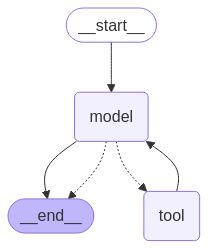

In [4]:
bar_chart_llm = build_llm()

# Define tool schema
class BarChartInput(BaseModel):
    """Input schema for the bar chart generator."""
    data: Dict[str, float] = Field(..., description="Dictionary where keys are labels and values are numeric values to plot")
    title: str = Field(default="Bar Chart", description="Title of the chart")
    
# Create the tool
@tool(args_schema=BarChartInput)
def generate_bar_chart(data: Dict[str, float], title: str) -> str:
    """Generate a bar chart from data points and display it.
    
    Parameters
    ----------
        data: Dict[str, float]
            Dictionary where keys are labels and values are numeric values to plot
        title: str
            Title of the chart (optional, defaults to "Bar Chart")
        
    Returns:
        plot as string
        
    Example:
        input = BarChartInput(
            data={"A": 10, "B": 20, "C": 15},
            title="Sample Chart"
        )
    """

    cats = list(data.keys())
    vals = list(data.values())
    plotext.clear_figure()
    plotext.bar(cats, vals)
    plotext.title(title)
    
    return plotext.build()


bar_chart_tools = [generate_bar_chart]
bar_chart_tool_node = ToolNode(tools=bar_chart_tools)

# Define agent node with tools
def bar_chart_model(state: AgentState):
    """Call the agent with the current state."""
    messages = state["messages"]
    result = bar_chart_llm.bind_tools(bar_chart_tools).invoke(messages)
    return {"messages": [result]}

def bar_chart_should_continue(state: AgentState):
    messages = state["messages"]
    ai_message = messages[-1]

    # Check if it's an AI message with tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool"
    return END
    
# Create and configure the graph
bar_chart_workflow = StateGraph(AgentState)
bar_chart_workflow.add_node("model", bar_chart_model)
bar_chart_workflow.add_node("tool", bar_chart_tool_node)

bar_chart_workflow.add_edge(START, "model")
bar_chart_workflow.add_edge("tool", "model")
bar_chart_workflow.add_conditional_edges(
    "model",
    bar_chart_should_continue,
    {
        "tool": "tool",
        END: END
    }
)
bar_chart_workflow.add_edge("model", END)

# Compile the graph
bar_chart_agent = bar_chart_workflow.compile()

display(Image(bar_chart_agent.get_graph().draw_mermaid_png()))

## Supervisor Agent

In [ ]:
team_members = ["researcher", "bar_chart_generator"]
END = "FINISH"
options = [END] + team_members

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the "
    "following workers: {team_members}. Given the following user request, "
    "respond with the worker to act next. Each worker will perform a task "
    "and respond with their results and status. When finished, respond with FINISH."
)

class RoutingSchema(BaseModel):
    next: Literal["FINISH", "researcher", "bar_chart_generator"]


prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="messages"),
    (
        "system",
        "Given the conversation above, who should act next? "
        "Or should we FINISH? Select one of: {options}"
    ),
])

formatted_prompt = prompt.partial(
    options=", ".join(options), team_members=", ".join(team_members)
)

# Initialize LLM
supervisor_llm = build_llm()

# Define supervisor
supervisor = formatted_prompt | supervisor_llm

input_variables=['messages'] input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.messages.function.Funct

In [6]:
# Invoke supervisor with a sample message
response1 = supervisor.invoke({
    "messages": [HumanMessage(content="Tell me the latest news on the stock market?")]
})
print(response1.content)  # Expected Output: {"next": "researcher"}

response2 = supervisor.invoke({
    "messages": [HumanMessage(content="Mike is 41, Joe is 30. Give me a visual representation of this data.")]
})
print(response2.content)  

response3 = supervisor.invoke({
    "messages": [HumanMessage(content="I'm done with my task.")]
})
print(response3.content)

researcher
bar_chart_generator
FINISH
